In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [2]:
#Load Data
df = pd.read_csv("../data/creditcard.csv")

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

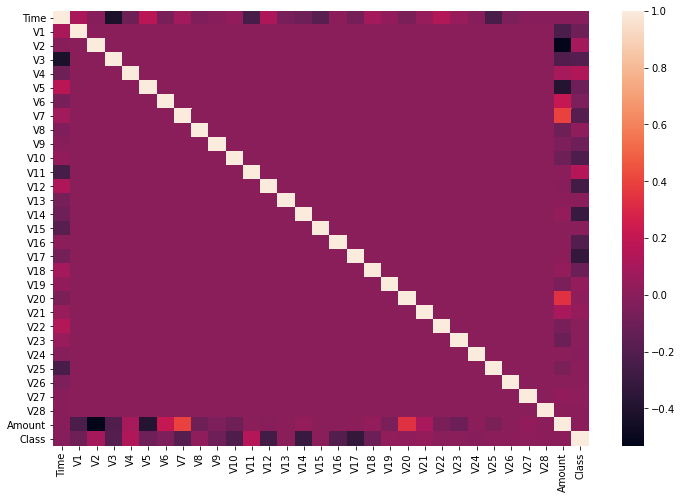

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr())

In [5]:
anomalies = df[df["Class"]==1]
no_anomalies = df[df["Class"]==0]

In [6]:
anomalies.shape

(492, 31)

In [7]:
no_anomalies.shape

(284315, 31)

In [8]:
print("number of samples :", df.shape[0])
print("number of anomalies : ", anomalies.shape[0])

number of samples : 284807
number of anomalies :  492


In [9]:
con_rate = anomalies.shape[0]/df.shape[0]
con_rate

0.001727485630620034

In [10]:
X = df.drop(columns = ['Class']).to_numpy()

In [11]:
y = df['Class'].to_numpy().flatten()

In [12]:
df_X = df.drop(columns = ['Class'])

In [13]:
def get_hour_data(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    
    X = _.drop(columns = ['Class']).to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [14]:
def get_hour_rate(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

In [15]:
rate = []
for i in range(48):
    rate.append(get_hour_rate(df, i))

In [16]:
rate

[0.0005049229992426155,
 0.0009025270758122744,
 0.013341804320203304,
 0.007138934651290499,
 0.005545286506469501,
 0.006543723973825104,
 0.0016384489350081922,
 0.006831006831006831,
 0.0009654373431164317,
 0.001904036557501904,
 0.00024131274131274132,
 0.005050505050505051,
 0.001164746991070273,
 0.0011867088607594937,
 0.001619735858460005,
 0.0017870819504723003,
 0.0017985611510791368,
 0.0015232292460015233,
 0.0017429700209156402,
 0.00087576629550857,
 0.0008911663139133341,
 0.0014154281670205238,
 0.00033437360677663843,
 0.002795592830126624,
 0.0010720986330742428,
 0.00399400898652022,
 0.020559680182752713,
 0.0023952095808383233,
 0.015111111111111112,
 0.0,
 0.002644336712208021,
 0.0,
 0.0007849293563579278,
 0.0001256281407035176,
 0.0007221954742416948,
 0.0011994722322178242,
 0.0010407180954858852,
 0.0010285420416559527,
 0.0011710973181871414,
 0.0013914656771799629,
 0.000923041421483789,
 0.002052644288819126,
 0.0021354846363744215,
 0.001567602873938602

In [17]:
from sklearn.neighbors import LocalOutlierFactor

In [18]:
y_true =[]
y_pred = np.array([])
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=5, 
                             algorithm='auto', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=rate[i]*10)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)

In [19]:
from sklearn.metrics import classification_report, accuracy_score
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
errors = (y_pred != y_true).sum() # Total number of errors is calculated.
errors

2815

In [20]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    141935
         1.0       0.49      0.05      0.09      2810

    accuracy                           0.98    144745
   macro avg       0.74      0.52      0.54    144745
weighted avg       0.97      0.98      0.97    144745



In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[141792,   2672],
       [   143,    138]], dtype=int64)

In [22]:
sum(y_true)

281.0

In [23]:
y_true =[]
y_pred = np.array([])
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=5, 
                             algorithm='auto', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=max(rate[i+24],0.0001)*10)
    X, y = get_hour_data(df, i+24)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)

In [24]:
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_pred != y_true).sum() # Total number of errors is calculated.
print(errors1)

2154


In [25]:
confusion_matrix(y_true, y_pred)

array([[137753,   2029],
       [   125,     86]], dtype=int64)

In [26]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    137878
         1.0       0.41      0.04      0.07      2115

    accuracy                           0.98    139993
   macro avg       0.70      0.52      0.53    139993
weighted avg       0.98      0.98      0.98    139993

